#Machine Learning in Python

#Lab 4: Multi-Layer Perceptron

> Jaryd Domine, Sharon Yang

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load, Split, and Balance

In [ ]:
import numpy as np
import pandas as pd

Load the data into memory and save it to a pandas data frame.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/acs2017_census_tract_data.csv')

Visualize missing data.

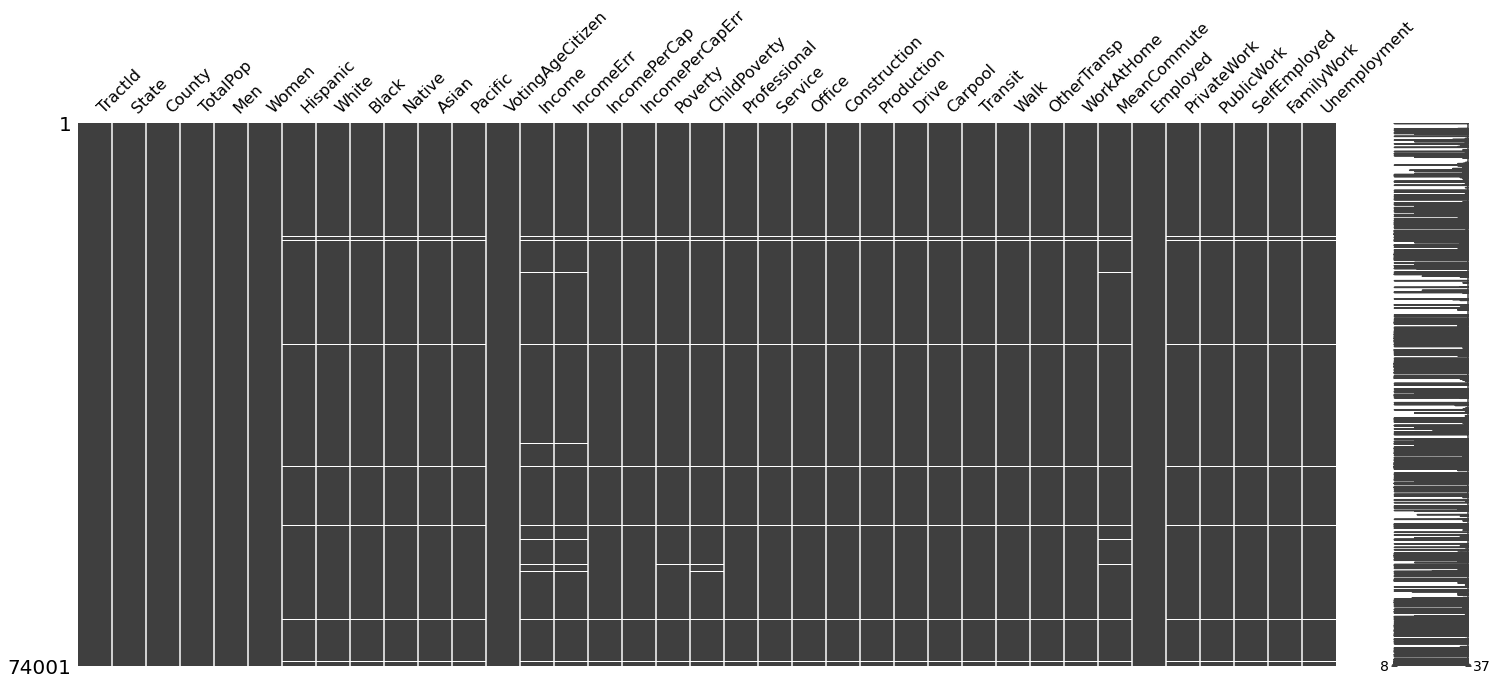

In [ ]:
import missingno as msno
msno.matrix(df)

Remove any observations that having missing data.

In [ ]:
df = df.dropna().reset_index(drop=True)

Remove the irrelevant features 'TractId' and 'County'.

In [ ]:
df.drop(columns=['TractId','County'],inplace=True)

Encode string data as integers.

In [ ]:
states     = df.State.unique()
state_dict = {states[i]:i   for i in range(len(states))}
df.State   = df['State'].map(state_dict)

Preview the data.

In [ ]:
df.sample(5)

,State,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
36377,24,3208,1810,1398,7.0,44.1,38.0,0.3,7.1,0.0,2268,31724.0,5214.0,18573.0,3170.0,38.0,65.9,16.2,32.1,20.8,21.6,9.4,87.3,6.1,3.9,0.4,0.9,1.4,16.2,1329,77.1,16.9,4.5,1.5,11.8
30643,20,5738,2561,3177,4.3,4.3,90.8,0.0,0.6,0.0,4136,50084.0,10253.0,36129.0,16969.0,10.5,5.2,21.2,40.4,20.3,7.1,11.0,47.1,13.5,34.0,3.5,1.4,0.5,34.7,2648,79.2,18.5,2.3,0.0,12.0
71042,49,1983,939,1044,67.2,31.4,0.3,0.0,0.0,0.0,792,60114.0,10119.0,17895.0,3001.0,20.9,29.4,25.5,30.1,24.5,7.1,12.8,73.4,22.1,0.3,0.9,0.0,3.2,23.7,886,87.1,12.9,0.0,0.0,3.8
48742,33,6866,4429,2437,19.1,60.9,11.3,2.1,1.4,0.4,5030,34688.0,4943.0,17135.0,1082.0,11.4,14.2,30.9,26.8,19.4,12.8,10.0,60.5,8.9,0.5,22.8,0.7,6.6,16.8,1219,64.1,33.1,2.8,0.0,15.2
33429,22,2957,1451,1506,1.2,88.0,8.9,0.0,0.5,0.0,2316,68241.0,5192.0,27346.0,2366.0,9.1,3.6,26.6,15.9,18.9,13.4,25.2,85.1,11.3,1.1,0.4,0.8,1.4,31.8,1431,88.5,8.4,3.1,0.0,5.5


Split the dataset into 80% for training and 20% for testing.

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(df.drop(columns=['ChildPoverty']))
y = np.array(df['ChildPoverty'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print([len(x) for x in (X_train,X_test,y_train,y_test)])

[58174, 14544, 58174, 14544]


Balance the dataset so that about the same number of instances are within each class. 

```ChildPoverty = % of children under the poverty level```

We use 'pd.qcut', a quantile-based discretization function, to determine ranges which equally divide the training data into four classes. With thereby avoid issues stemming from class imbalance.

The quantile cut is calculated on the training data and then applied to both the train and test sets. The test set should not be included during calculation because we don't know its distribution yet, and balancing it based on the quantization thresholds calculated from the training dataset will cause data snooping.


Calculate quantiles on the training set and apply to the training set.

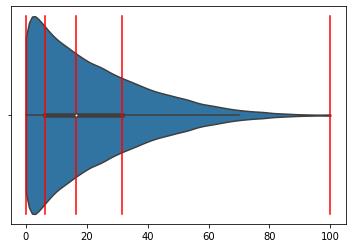

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

N_QUANTILES = 4

y_train_bins,edges = pd.qcut(y_train,N_QUANTILES,labels=range(N_QUANTILES),retbins=True)
sns.violinplot(x=y_train,cut=0)

# balance the data on both training and testing, is it causing data snooping?
#y_bins,edges = pd.qcut(y,N_QUANTILES,labels=range(N_QUANTILES),retbins=True)
#sns.violinplot(y,cut=0)
for edge in edges:
    plt.plot((edge,edge),(-.4,.4),c='red')

Apply the same cuts to the test set. Visualize the resulting class distribution in the test set.

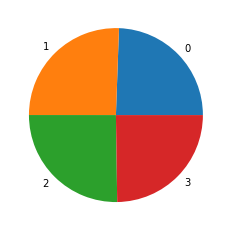

In [ ]:
y_test_bins = pd.cut(y_test,edges,labels=range(N_QUANTILES),include_lowest=True)

labels,counts = np.unique(y_test_bins,return_counts=True)
plt.pie(counts,labels=labels);

One-hot encode the target.

In [ ]:
y_train_onehot = pd.get_dummies(y_train_bins)
y_test_onehot  = pd.get_dummies(y_test_bins)

##Pre-processing

###Example 2-layer network

The following 2-layer network code is taken from class notebook 8.

Base classifier

In [ ]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0,size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_/2.0) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        """
        A1 = self._add_bias_unit(X, how='column')
        A1 = A1.T
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)  # last layer sensitivity
        V1 = A2*(1-A2)*(W2.T @ V2) # back prop the sensitivity 
        
        grad2 = V2 @ A2.T # no bias on final layer
        grad1 = V1[1:,:] @ A1.T # dont back prop sensitivity of bias
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred

Mini-batching

In [ ]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class TLPMiniBatch(TwoLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)

        self.cost_ = []
        self.score_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, 
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1,W2=self.W2)

                # momentum calculations
                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        return self

Cross entropy objective function

In [ ]:
# to implement the new style of objective function, 
# we just need to update the final layer calculation of the gradient
class TLPMiniBatchCrossEntropy(TLPMiniBatch):
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2

Glorot initialization

In [ ]:
class TLPBetterInitial(TLPMiniBatchCrossEntropy):             
    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2

Utility functions

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

def print_result(nn,X_train,y_train,X_test,y_test,title="",color="red"):
    
    print("=================")
    print(title,":")

    ### yang
    #qt = QuantileTransformer()
    #ttr = TransformedTargetRegressor(regressor=nn, transformer=qt)
    #pipe = Pipeline([('ttr', ttr)])

    #pipe.fit(X_train, y_train)
    #yhat = pipe.fit(X_train)
    ###

    yhat = nn.predict(X_train)
    print(yhat)
    print('Resubstitution acc:',accuracy_score(y_train,yhat))
    

    #yhat = pipe.fit(X_test) 
    yhat = nn.predict(X_test)
    print('Validation acc:',accuracy_score(y_test,yhat))
    
    if hasattr(nn,'val_score_'):
        plt.plot(range(len(nn.val_score_)), nn.val_score_, color=color,label=title)
        plt.ylabel('Validation Accuracy')
    else:
        plt.plot(range(len(nn.score_)), nn.score_, color=color,label=title)
        plt.ylabel('Resub Accuracy')
    
    plt.ylim((0,1))
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

###2-layer performance 

Train the model without normalizing or one-hot encoding the data.

Epoch: 500/500

CPU times: user 4min 59s, sys: 3min 43s, total: 8min 43s
Wall time: 4min 30s
Glorot Initial :
[3 3 3 ... 3 3 3]
Resubstitution acc: 0.24894282669233678
Validation acc: 0.2475935093509351


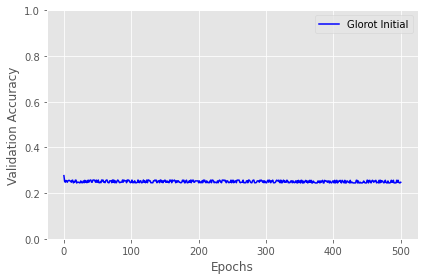

In [ ]:
vals = {'n_hidden':50, 
         'C':1e-2, 'epochs':75, 'eta':0.01, 
         'alpha':0.1, 'decrease_const':0.1, 'minibatches':len(X_train)/256,
         'shuffle':True,'random_state':1}

def train_and_quantify(X_train,X_test,y_train,y_test,epochs=10):
    vals['epochs'] = epochs

    # nn_tradit = TLPMiniBatchCrossEntropy(**vals)
    nn_better = TLPBetterInitial(**vals)

    # %time nn_tradit.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))
    %time nn_better.fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

    # print_result(nn_tradit,X_train,y_train,X_test,y_test,title="Traditional",color="red")
    print_result(nn_better,X_train,y_train,X_test,y_test,title="Glorot Initial",color="blue")
    plt.show()

train_and_quantify(X_train,X_test,y_train_bins,y_test_bins,epochs=500)
#train_and_quantify(X_train,X_test,y_train_onehot,y_test_onehot,epochs=20)

We quickly converge to 25% accuracy, comparable to random guessing. After 500 epochs, no improvement was noticed.

Normalize the continuous numeric feature data, and train again.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)

# Keep categorical data the same
X_train_norm[:,0] = X_train[:,0]
X_test_norm[:,0] = X_test[:,0]

Epoch: 100/100

CPU times: user 1min 2s, sys: 46.9 s, total: 1min 49s
Wall time: 56.5 s
Glorot Initial :
[2 3 1 ... 1 3 1]
Resubstitution acc: 0.7130505036614295
Validation acc: 0.7026265126512651


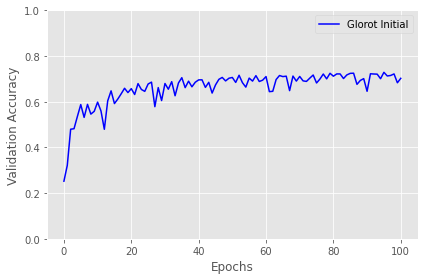

In [ ]:
train_and_quantify(X_train_norm,X_test_norm,y_train_bins,y_test_bins,epochs=100)

With normalized continuous features, the network took roughly 50 epochs to converge. Accuracy fluctuates in the range 65%-74%.

Additionally one hot encode the categorical data, and then train again.

In [ ]:
state_onehot_train = np.array(pd.get_dummies(X_train[:,0]))
state_onehot_test  = np.array(pd.get_dummies(X_test[:,0]))

X_train_norm_onehot = np.hstack(( state_onehot_train, X_train_norm[:,1:] ))
X_test_norm_onehot  = np.hstack(( state_onehot_test,  X_test_norm[:,1:] ))

Preview the data.

In [ ]:
pd.DataFrame(X_train_norm_onehot).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
4454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327383,0.180231,0.461039,-0.420664,0.526356,-0.248870,-0.138929,0.003925,-0.147398,0.329913,4.615358,0.941056,4.682360,1.964767,-1.023878,2.751754,-1.524346,-2.026643,-1.106715,-1.491080,-0.447653,-0.535817,0.167118,-0.232913,0.124824,2.222479,0.609776,0.445392,-1.721319,1.022066,1.568111,0.964646,-0.922208
10785,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.114650,-0.251117,0.021582,-0.186801,-0.012199,0.251339,-0.160976,0.059310,-0.147398,0.151427,-0.761760,-0.442524,-0.503666,-0.543653,-0.140786,-1.020183,1.159654,0.907838,0.188780,-0.014069,0.161239,0.325463,-0.177433,-0.384859,0.403976,-0.264464,-0.151126,0.191923,0.236985,0.116118,-0.672308,-0.382849,-0.200191
32969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.066345,0.119260,-0.245104,-0.749806,1.051856,-0.489711,-0.160976,-0.472394,-0.147398,0.070116,-0.656430,-0.627254,-0.368821,0.606912,0.364985,-0.022316,-1.260963,-0.112073,-0.130888,1.568443,0.502486,-1.025180,-0.289412,-0.403852,1.201552,0.026561,-0.785210,-0.210069,-0.503656,0.980253,-0.725024,-0.382849,-0.375817
49016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070447,-0.076394,-0.062588,-0.234439,-1.908566,-0.610132,18.623157,-0.527780,-0.147398,-0.220751,-1.026138,-0.359930,-1.304493,-0.990645,2.002719,-1.013530,1.786756,0.496295,-0.114063,-0.132757,0.395428,0.873549,-0.461687,-0.403852,0.204582,-0.899429,-0.094763,-0.877982,-1.206636,1.802575,-0.830455,-0.382849,0.795022
51563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.950867,-0.950920,-0.922895,-0.546258,0.588372,-0.577711,-0.160976,0.845790,-0.147398,-0.959817,2.708696,2.406246,1.970105,3.086297,-1.072046,1.361393,-1.072832,0.782586,-1.123540,-1.266891,-0.026112,-0.437944,-0.091295,-0.555799,-0.154327,1.852083,0.891592,-0.724122,0.450390,-0.971020,-0.329656,10.172524,-0.200191


Train the network on the normalized/one-hot encoded data.

Epoch: 20/20

CPU times: user 15 s, sys: 9.86 s, total: 24.8 s
Wall time: 12.9 s
Glorot Initial :
[2 3 1 ... 1 3 1]
Resubstitution acc: 0.7417059167325609
Validation acc: 0.7374174917491749


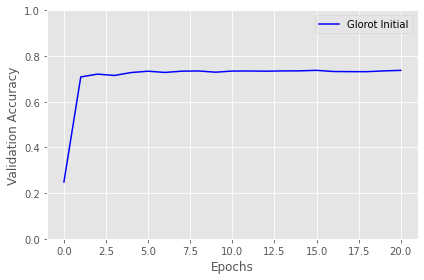

In [ ]:
train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,epochs=20)

We note rapid convergence ($<5$ epochs) to a validation accuracy of ~74%.

###Compare the performance of the three models

Among the three models, normalizing the continuous numeric feature data *and* one-hot encoding the categorical data provided the highest validation accuracy at ~74%.

It additionally converged 10x faster than the second (not one-hot encoded) model. The second and third model approached roughly the same accuracy, but the third was more stable.

A test showed that simply normalizing the "State" feature provided the same increase in performance as one-hot encoding it. This suggests that the lack of normalization of the feature was the main issue, which one-hot encoding resolved.

The first model converged immediately to 25% (random) accuracy. None of the features were normalized. Each feature has a different interval and makes it harder to find the minimum during gradient descent. The sigmoid is flooded with large values where the derivative is extremely small.



##Modeling

We generlize the example 2-layer network to support N layers.

The general strategy is as follows:
* Change the "n_hidden" parameter to list type
    * Allow the user to specify the number of nodes in each hidden layer, e.g. [30], [50,25,12], [4,3,2,1]

* Update all methods to involve first layer and last layer code, with loops to handle the interior layers.
    * e.g. Glorot initialization will give internal weight matrices of size ```(self.n_hidden[i+1], self.n_hidden[i] + 1)```

Implemented techniques include
* Glorot initialization
* Cross-entropy objective function
* Minibatching
* Momentum
* Cooling

We also record the mean magnitude of the gradient for each layer for each epoch.

###Multi-layer perceptron

Base class.
Built-in Glorot initialization and Cross entropy.

In [ ]:
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
import numpy as np
from scipy.special import expit
import pandas as pd
import sys

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
class NLayerPerceptronBase(object):
    def __init__(self, n_hidden=[30,6],
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        assert 0 not in n_hidden
        self.n_W = len(n_hidden) + 1
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot
    
    def _initialize_weights(self): #Glorot
        """Initialize weights Glorot and He normalization."""

        W = np.array([None for layer in range(self.n_W)], dtype=object)
        
        #weights between input and first hidden layer
        init_bound = 4*np.sqrt(6. / (self.n_hidden[0] + self.n_features_ + 1))
        W[0] = np.random.uniform(-init_bound, init_bound,(self.n_hidden[0], self.n_features_ + 1))
        W[0][:,:1] = 0

        #weights between hidden layers
        for i in range(len(self.n_hidden)-1): #for every pair of hidden layers
            init_bound = 4*np.sqrt(6. / (self.n_hidden[i+1] + self.n_hidden[i] + 1))
            W[i+1] = np.random.uniform(-init_bound, init_bound,(self.n_hidden[i+1], self.n_hidden[i] + 1))
            W[i+1][:,:1] = 0

        # weights between output and last hidden layer
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden[-1] + 1))
        W[-1] = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden[-1] + 1)) 
        W[-1][:,:1] = 0
        
        return W
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms

        mean_square = 0
        for w in W:
            mean_square += np.mean(w[:, 1:] ** 2)

        return (lambda_/2.0) * np.sqrt(mean_square)
    
    def _cost(self,A,Y_enc,W): #Cross entropy
        '''Get the objective function value'''
        cost = -np.mean(np.nan_to_num((Y_enc*np.log(A[-1])+(1-Y_enc)*np.log(1-A[-1]))))
        L2_term = self._L2_reg(self.l2_C, W)
        return cost + L2_term
    
    def _feedforward(self, X, W):
        """Compute feedforward step
        """

        A = np.array([None for i in range(self.n_W + 1)], dtype=object)
        Z = np.array([None for i in range(self.n_W)], dtype=object)

        #input to first hidden layer
        A[0] = self._add_bias_unit(X, how='column')
        A[0] = A[0].T
        Z[0] = W[0] @ A[0]

        #loop over every pair of hidden layers
        for i in range(len(self.n_hidden)):
            A[i+1] = self._sigmoid(Z[i])
            A[i+1] = self._add_bias_unit(A[i+1], how='row')
            Z[i+1] = W[i+1] @ A[i+1]

        #last hidden layer to output
        A[-1] = self._sigmoid(Z[-1])

        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc, W): #Cross entropy gradient
        """ Compute gradient step using backpropagation.
        """
        V    = np.array([None for i in range(self.n_W)], dtype=object) #sensitivities
        grad = np.array([None for i in range(self.n_W)], dtype=object) #gradient

        #====Sensitivity calculations====
        #last layer sensitivity
        V[-1] = A[-1]-Y_enc
        V[-2] = A[-2]*(1-A[-2])*(W[-1].T @ V[-1])

        #backpropagate the sensitivity
        for i in range(len(self.n_hidden)-1,0,-1):
            # print('\n',i)
            # print('\tA'+str(i),A[i].shape,'W.T'+str(i),W[i].T.shape,'V'+str(i),V[i].shape)
            # print(W[i][:,1:].T @ V[i])
            V[i-1] = A[i]*(1-A[i])*(W[i].T @ V[i][1:,:])

        #====Gradient calculations====
        grad[-1] = V[-1] @ A[-2].T# no bias on final layer
        for i in range(self.n_W-1): #for every hidden layer
            grad[i] = V[i][1:, :] @ A[i].T # dont back prop sensitivity of bias

        # regularize weights that are not bias terms
        for i in range(self.n_W):
            grad[i][:, 1:] += W[i][:, 1:] * self.l2_C

        return grad
    
    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X, self.W)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred

Convenience function to make a network with half as many nodes at each consecutive layer

In [ ]:
def funnel(num_hidden_layers=2, first_hidden_size=30):
    n_hidden = [np.int(np.round(first_hidden_size*((1/2)**i))) for i in range(num_hidden_layers)]
    assert 0 not in n_hidden
    return n_hidden

funnel(4,50)

[50, 25, 12, 6]

Implementation of minibatching, momentum, and cooling.

In [ ]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class NLayerTLPMiniBatch(NLayerPerceptronBase):
    def __init__(self, alpha=0.0, decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        rho_W_prev = np.array([np.zeros(self.W[i].shape) for i in range(self.n_W)], dtype=object)

        self.cost_  = []
        self.score_ = []
        self.mean_grad_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):

            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx],
                                         self.W)
                
                cost = self._cost(A,Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                # momentum calculations
                rho_W   = eta * grad
                self.W -= rho_W + (self.alpha * rho_W_prev)
                rho_W_prev = rho_W

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.mean_grad_.append([np.mean(np.abs(w)) for w in grad])
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        print('')
        self.mean_grad_ = np.array(self.mean_grad_)

        return self

In [ ]:
# a = []
# a.append([1,2,3])
# a.append([1,2,3])
# a.append([1,2,3])
# a = np.array(a)
# a.min(axis=1)

array([1, 1, 1])

###Train and quantify

Function to plot the validation accuracy and mean gradient magnitude of a set of models, with big-picture and close-up plots side by side.

For mean gradient magnitude, the plot shows the mean of *all* layers as a solid line, and shades within the range of the max and min across the layers.

In [ ]:
def print_result_multiple(models,X_train,y_train,X_test,y_test,title=""):
    
    print("=================")
    print(title,":")

    yhat = [model.predict(X_train) for model in models]
    # print(yhat)
    print('Resubstitution acc:')
    for m,model in enumerate(models):
        yhat = model.predict(X_train)
        print('\tmodel',m,model.n_hidden,':',accuracy_score(y_train,yhat))
    
    print('Validation acc:')
    for m,model in enumerate(models):
        yhat = model.predict(X_test)
        print('\tmodel',m,model.n_hidden,':',accuracy_score(y_test,yhat))

    fig,ax = plt.subplots(2,2,figsize=(10,10))
    # plt.figure(figsize=(6,6))

    for m,model in enumerate(models):
        #=== Plot scores ===
        if hasattr(model,'val_score_'):
            n_scores = len(model.val_score_)
            ax[0][0].plot(range(n_scores), model.val_score_,label='model'+str(m)+str(model.n_hidden))
            ax[0][0].set_ylabel('Validation Accuracy')

            subset = range(n_scores)[(n_scores+1)//2:]
            ax[0][1].plot(subset, model.val_score_[min(subset):],label='model'+str(m)+str(model.n_hidden))

        else:
            n_scores = len(model.score_)
            ax[0][0].plot(range(n_scores), model.score_,label='model'+str(m)+str(model.n_hidden))
            ax[0][0].set_ylabel('Resub Accuracy')

            subset = range(n_scores)[(n_scores+1)//2:]
            ax[0][1].plot(subset, model.score_[min(subset):],label='model'+str(m)+str(model.n_hidden))

        #=== Plot mean gradients ===
        n_grads = len(model.mean_grad_)
        mag_mean = model.mean_grad_.mean(axis=1)
        mag_lo   = model.mean_grad_.min(axis=1)
        mag_hi   = model.mean_grad_.max(axis=1)

        ax[1][0].plot(range(n_grads), mag_mean, label='model'+str(m)+str(model.n_hidden))
        ax[1][0].fill_between(range(n_grads), mag_lo, mag_hi, alpha=0.25)#, label='model'+str(m)+str(model.n_hidden))
        ax[1][0].set_ylabel('Mean Gradient Magnitude')

        subset = range(n_grads)[(n_grads+1)//2:]
        ax[1][1].plot(subset, mag_mean[min(subset):], label='model'+str(m)+str(model.n_hidden))
        ax[1][1].fill_between(subset, mag_lo[min(subset):], mag_hi[min(subset):], alpha=0.25)#,label='model'+str(m)+str(model.n_hidden))

    plt.title(title)
    ax[0][0].set_ylim((0,1))
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend(loc='best')
    plt.grid(True)

Convenience function to run many models

In [ ]:
Nlayer_defaults = {'n_hidden':[6,6], 
                    'C':1e-2, 'epochs':30, 'eta':0.01, 
                    'alpha':0.1, 'decrease_const':0.1, 'minibatches':len(X_train)/256,
                    'shuffle':True,'random_state':1}

def Nlayer_train_and_quantify(X_train,X_test,y_train,y_test,params=None):
    #each set of params given will be used in a separate model
    if type(params) not in [set,list,tuple]: params = [params]

    models = [None]*len(params)
    for m in range(len(models)):

        model_params = Nlayer_defaults.copy()
        for p in params[m]:
            if p not in model_params: continue
            model_params[p] = params[m][p]

        models[m] = NLayerTLPMiniBatch(**model_params)
        %time models[m].fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

    print_result_multiple(models,X_train,y_train,X_test,y_test)
    plt.show();

Compare the performance of 2, 3, 4 and 5-layer networks.

Epoch: 30/30


CPU times: user 17.9 s, sys: 12.1 s, total: 30 s
Wall time: 15.6 s


Epoch: 30/30


CPU times: user 22.3 s, sys: 16.6 s, total: 38.9 s
Wall time: 20.1 s


Epoch: 30/30


CPU times: user 24.8 s, sys: 18.6 s, total: 43.4 s
Wall time: 22.4 s


Epoch: 30/30


CPU times: user 26.5 s, sys: 19.8 s, total: 46.3 s
Wall time: 23.9 s
 :
Resubstitution acc:
	model 0 [30] : 0.7394712414480696
	model 1 [30, 15] : 0.7410527039570942
	model 2 [30, 15, 8] : 0.7432701894317049
	model 3 [30, 15, 8, 4] : 0.7373225152129818
Validation acc:
	model 0 [30] : 0.7354235423542355
	model 1 [30, 15] : 0.7366611661166117
	model 2 [30, 15, 8] : 0.7355610561056105
	model 3 [30, 15, 8, 4] : 0.7255225522552256


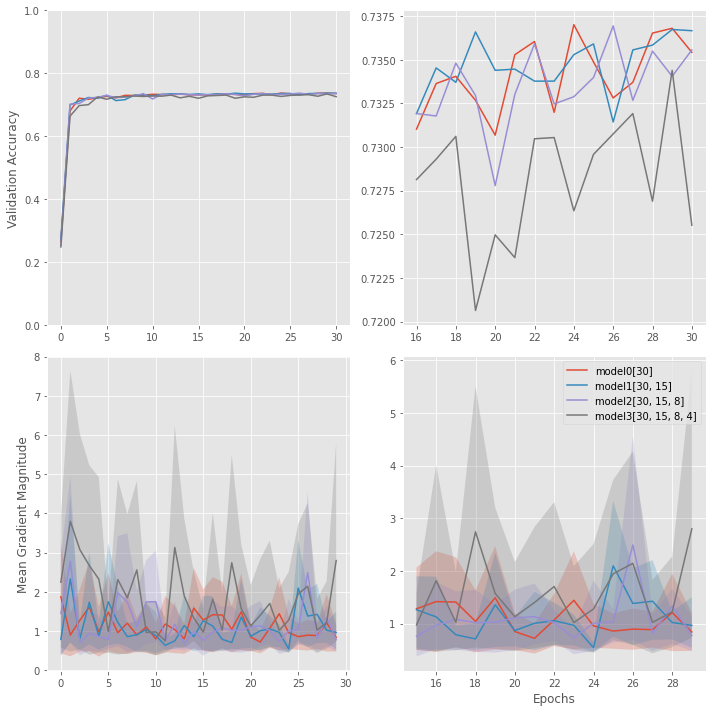

In [ ]:
Nlayer_train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,
                          params=[#{'n_hidden':[1],'epochs':10},
                                  {'n_hidden':[30]},
                                  {'n_hidden':[30,15]},
                                  {'n_hidden':[30,15,8]},
                                  {'n_hidden':[30,15,8,4]}]
                                #   {'n_hidden':funnel(6,200)}]
                          )

All models show converged  accuracies between 72% and 73.75%.

The 5-layer network is less stable, with accuracy roughly 0.5% lower than the other models.

The 5-layer network also has the highest mean gradient magnitudes of all models. This agrees with the lack of stability in its accuracy score.


---

Compare models with and without momentum and cooling.

Epoch: 30/30


CPU times: user 26.6 s, sys: 18.7 s, total: 45.3 s
Wall time: 23.4 s


Epoch: 30/30


CPU times: user 26.4 s, sys: 18.7 s, total: 45.1 s
Wall time: 23.3 s


Epoch: 30/30


CPU times: user 26.3 s, sys: 18.7 s, total: 45 s
Wall time: 23.2 s


Epoch: 30/30


CPU times: user 26.5 s, sys: 18.8 s, total: 45.3 s
Wall time: 23.4 s
 :
Resubstitution acc:
	model 0 [30, 15, 8, 4] : 0.7373225152129818
	model 1 [30, 15, 8, 4] : 0.7383882834255853
	model 2 [30, 15, 8, 4] : 0.7186543816825386
	model 3 [30, 15, 8, 4] : 0.7166431739264963
Validation acc:
	model 0 [30, 15, 8, 4] : 0.7255225522552256
	model 1 [30, 15, 8, 4] : 0.730541804180418
	model 2 [30, 15, 8, 4] : 0.7072332233223322
	model 3 [30, 15, 8, 4] : 0.7055830583058306


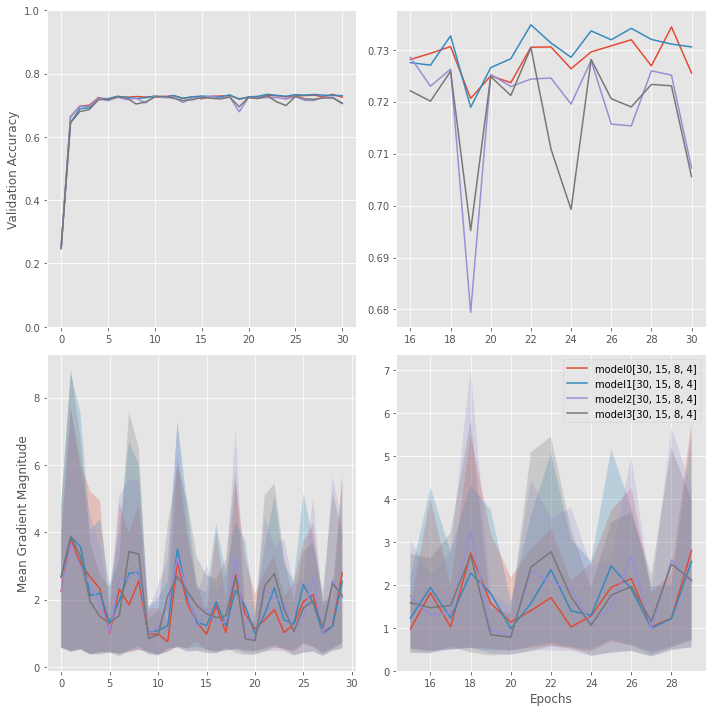

In [ ]:
Nlayer_train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,
                          params=[{'n_hidden':[30,15,8,4],'alpha':0.1,'decrease_const':0.1},
                                  {'n_hidden':[30,15,8,4],'alpha':0.0,'decrease_const':0.1},
                                  {'n_hidden':[30,15,8,4],'alpha':0.1,'decrease_const':0.0},
                                  {'n_hidden':[30,15,8,4],'alpha':0.0,'decrease_const':0.0}]
                          )
# Nlayer_train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,
#                           params=[{'n_hidden':[2],'alpha':1},
#                                   {'n_hidden':[2],'alpha':0.1},
#                                   {'n_hidden':[2],'alpha':0}]
#                           )

In order, we have:
* *model0*: Both momentum and cooling active. Cooling has stabilized the solution, while momentum shows little noticable effect.
* *model1*: Only cooling, no momentum. Cooling has stabilized the solution. The accuracy is marginally higher than *model0* in the last epochs.
* *model2*: Only momentum, no cooling. The accuracy is erratic when training is not slowed by cooling.
* *model3*: Neither cooling nor momentum. Same behavior as *model2*.

These techniques have no apparent effect on the gradient magnitudes.



We perform another test on cooling, comparing the performance of rapid (1), slow (0.1), and no (0) cooling.

Epoch: 75/75


CPU times: user 59.1 s, sys: 40.5 s, total: 1min 39s
Wall time: 51.3 s


Epoch: 75/75


CPU times: user 59.1 s, sys: 40.7 s, total: 1min 39s
Wall time: 51.4 s


Epoch: 75/75


CPU times: user 59 s, sys: 41.2 s, total: 1min 40s
Wall time: 51.6 s
 :
Resubstitution acc:
	model 0 [30, 15, 8, 4] : 0.7415340186337539
	model 1 [30, 15, 8, 4] : 0.7486677897342455
	model 2 [30, 15, 8, 4] : 0.7455220545260769
Validation acc:
	model 0 [30, 15, 8, 4] : 0.7337046204620462
	model 1 [30, 15, 8, 4] : 0.7347359735973598
	model 2 [30, 15, 8, 4] : 0.7297854785478548


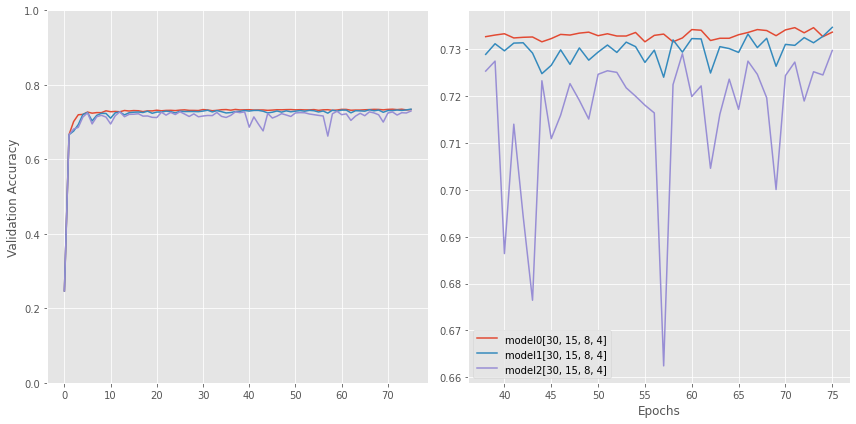

In [ ]:
Nlayer_train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,
                          params=[{'n_hidden':[30,15,8,4],'decrease_const':1},
                                  {'n_hidden':[30,15,8,4],'decrease_const':0.1},
                                  {'n_hidden':[30,15,8,4],'decrease_const':0}]
                          )

The model with rapid-cooling model maintained a higher (by ~0.25%) accuracy than the slow-cooling model in the last epochs.

The model without cooling was erratic to the end, with accuracy as much as 7% lower than the other models.

##Exceptional Work

###AdaM optimizer

Implement adaptive momentum (AdaM) for an N-layer neural network and quantify the performance.

In [ ]:
from sklearn.metrics import accuracy_score
# just start with the vectorized version and minibatch
class NLayerTLPMiniBatch_AdaM(NLayerPerceptronBase):
    def __init__(self, beta1=0.9, beta2=0.999, eps=10e-8,
                 decrease_const=0.0, shuffle=True, 
                 minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    
    def fit(self, X, y, print_progress=False, XY_test=None):
        """ Learn weights from training data. With mini-batch"""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W = self._initialize_weights()

        W_prev = np.array([np.zeros(self.W[i].shape) for i in range(self.n_W)], dtype=object)
        M_prev = W_prev.copy()
        V_prev = W_prev.copy()

        self.cost_ = []
        self.score_ = []
        self.mean_grad_ = []
        # get starting acc
        self.score_.append(accuracy_score(y_data,self.predict(X_data)))
        # keep track of validation, if given
        if XY_test is not None:
            X_test = XY_test[0].copy()
            y_test = XY_test[1].copy()
            self.val_score_ = []
            self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
            
        for i in range(self.epochs):
            
            # adaptive learning rate
            # \frac{\eta}{1+\epsilon\cdot k}
            eta = self.eta / (1 + self.decrease_const*i)

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx_shuffle = np.random.permutation(y_data.shape[0])
                X_data, Y_enc, y_data = X_data[idx_shuffle], Y_enc[:, idx_shuffle], y_data[idx_shuffle]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A, Z = self._feedforward(X_data[idx],
                                         self.W)
                
                cost = self._cost(A,Y_enc[:, idx],self.W)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad = self._get_gradient(A, Z, Y_enc[:, idx], self.W)

                #=========================
                #=== AdaM calculations ===
                #=========================

                M = self.beta1 * M_prev + (1-self.beta1) * grad
                V = self.beta2 * V_prev + (1-self.beta2) * grad**2

                k = i+1
                M_hat = M / (1 - self.beta1**k)
                V_hat = V / (1 - self.beta2**k)

                self.W = W_prev - eta * M_hat / (V_hat + self.eps)**.5

                W_prev = self.W
                M_prev = M
                V_prev = V

            self.cost_.append(mini_cost)
            self.score_.append(accuracy_score(y_data,self.predict(X_data)))
            self.mean_grad_.append([np.mean(np.abs(w)) for w in grad])
            if XY_test is not None:
                self.val_score_.append(accuracy_score(y_test,self.predict(X_test)))
        print('')
        self.mean_grad_ = np.array(self.mean_grad_)

        return self

Define new convenience functions for the AdaM classes.

In [ ]:
Nlayer_AdaM_defaults = {'n_hidden':[6,6], 
                        'C':1e-2, 'epochs':50,
                        'beta1':0.9, 'beta2':0.999, 'eta':0.1, 'eps':10e-8,
                        'decrease_const':0.1, 'minibatches':len(X_train)/256,
                        'shuffle':True,'random_state':1}

def Nlayer_AdaM_train_and_quantify(X_train,X_test,y_train,y_test,params=None):
    #each set of params given will be used in a separate model
    if type(params) not in [set,list,tuple]: params = [params]

    models = [None]*len(params)
    for m in range(len(models)):

        model_params = Nlayer_AdaM_defaults.copy()
        for p in params[m]:
            if p not in model_params: continue
            model_params[p] = params[m][p]

        models[m] = NLayerTLPMiniBatch_AdaM(**model_params)
        %time models[m].fit(X_train, y_train, print_progress=1, XY_test=(X_test, y_test))

    print_result_multiple(models,X_train,y_train,X_test,y_test)
    plt.show();

Quantify performance on the 5-layer network with AdaM, again with various cooling parameters.

Epoch: 50/50


CPU times: user 45.9 s, sys: 32.7 s, total: 1min 18s
Wall time: 40.6 s


Epoch: 50/50


CPU times: user 45.9 s, sys: 32.5 s, total: 1min 18s
Wall time: 40.4 s


Epoch: 50/50


CPU times: user 45.5 s, sys: 32.5 s, total: 1min 18s
Wall time: 40.2 s
 :
Resubstitution acc:
	model 0 [30, 15, 8, 4] : 0.7352769278371781
	model 1 [30, 15, 8, 4] : 0.7496647987073263
	model 2 [30, 15, 8, 4] : 0.7396947089765187
Validation acc:
	model 0 [30, 15, 8, 4] : 0.7334295929592959
	model 1 [30, 15, 8, 4] : 0.7364548954895489
	model 2 [30, 15, 8, 4] : 0.7256600660066007


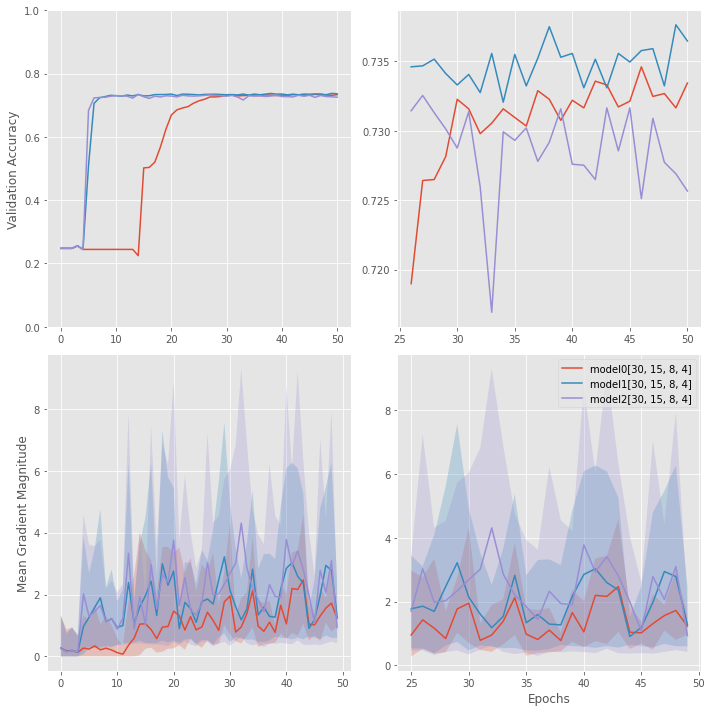

In [ ]:
Nlayer_AdaM_train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,
                                params=[{'n_hidden':[30,15,8,4],'decrease_const':1},
                                        {'n_hidden':[30,15,8,4],'decrease_const':0.1},
                                        {'n_hidden':[30,15,8,4],'decrease_const':0}]
                           )
#Nlayer_AdaM_train_and_quantify(X_train_norm_onehot,X_test_norm_onehot,y_train_bins,y_test_bins,
#                               params=[{'n_hidden':[2],'decrease_const':1},
#                                       {'n_hidden':[2],'decrease_const':0.1},
#                                       {'n_hidden':[2],'decrease_const':0}]
#                          )

The model with rapid cooling ("model0") converged considerably slower than the others. It appears to have gotten "trapped" twice before converging, once at 25% accuracy and once at 50% accuracy.

All models showed validation accuracy between 72% and 74%.

Notice from the mean gradient magnitude chart that all models had a period of "inaction" where the gradient was near zero. The mean gradient then plateaus around 2. The rapid cooling model has the lowest gradient on average, and the no cooling model has the highest gradient.

---

We additionally compute a confusion matrix and find behavior to be expected of an ordinal target variable. When the model is incorrect, it is more likely to choose a poverty class adjacent to the true poverty class.

In [ ]:
from sklearn.metrics import confusion_matrix

nn = NLayerTLPMiniBatch_AdaM(**{'n_hidden':[2], 
                                'C':1e-2, 'epochs':75,
                                'beta1':0.9, 'beta2':0.999, 'eta':0.01, 'eps':10e-8,
                                'decrease_const':0.1, 'minibatches':len(X_train)/256,
                                'shuffle':True,'random_state':1})
%time nn.fit(X_train_norm_onehot, y_train_bins, print_progress=1, XY_test=(X_test_norm_onehot, y_test_bins))

yhat = nn.predict(X_test_norm_onehot)
confusion_matrix(y_test_bins,yhat)

Epoch: 75/75


CPU times: user 19.6 s, sys: 9.37 s, total: 28.9 s
Wall time: 18.3 s


array([[3092,  399,  124,   52],
       [1039, 1524,  999,   68],
       [  44,  377, 2651,  584],
       [   7,   11,  462, 3111]])

###Scratch work

In [ ]:
    # def _cost(self, A, Y_enc, W):
    #     '''Get the objective function value'''
    #     cost = np.mean((Y_enc-A[-1])**2)
    #     L2_term = self._L2_reg(self.l2_C, W)
    #     return cost + L2_term
   
    # def _get_gradient(self, A, Z, Y_enc, W):
    #     """ Compute gradient step using backpropagation.
    #     """

    #     V    = np.array([np.zeros(1) for i in range(n_W)], dtype=object) #sensitivities
    #     grad = np.array([np.zeros(1) for i in range(n_W)], dtype=object) #gradient

    #     #====Sensitivity calculations====
    #     #last layer sensitivity
    #     V[-1] = -2*(Y_enc-A[-1])*A[-1]*(1-A[-1]) 

    #     #backpropagate the sensitivity
    #     for i in range(len(n_hidden)-1,0,-1):
    #         V[i-1] = A[i]*(1-A[i])*(W[i].T @ V[i])

    #     #====Gradient calculations====
    #     grad[-1] = V[-1] @ A[-2].T# no bias on final layer
    #     for i in range(len(grad)-1): #for every hidden layer
    #         grad[i] = V[i][1:,:] @ A[i].T # dont back prop sensitivity of bias
                
    #     # regularize weights that are not bias terms
    #     for i in range(len(grad)):
    #         grad[i][:, 1:] += W[i][:, 1:] * self.l2_C

    #     return grad

In [ ]:
# # to implement the new style of objective function, 
# # we just need to update the final layer calculation of the gradient
# class NLayerTLPMiniBatchCrossEntropy(NLayerTLPMiniBatch):
#     def _cost(self,A,Y_enc,W):
#         '''Get the objective function value'''
#         cost = -np.mean(np.nan_to_num((Y_enc*np.log(A[-1])+(1-Y_enc)*np.log(1-A[-1]))))
#         L2_term = self._L2_reg(self.l2_C, W)
#         return cost + L2_term
    
#     def _get_gradient(self, A, Z, Y_enc, W):
#         """ Compute gradient step using backpropagation.
#         """
#         V    = np.array([np.zeros(1) for i in range(n_W)], dtype=object) #sensitivities
#         grad = np.array([np.zeros(1) for i in range(n_W)], dtype=object) #gradient

#         #====Sensitivity calculations====
#         #last layer sensitivity
#         V[-1] = A[-1]-Y_enc

#         #backpropagate the sensitivity
#         for i in range(len(n_hidden)-1,0,-1):
#             V[i-1] = A[i]*(1-A[i])*(W[i].T @ V[i])

#         #====Gradient calculations====
#         grad[-1] = V[-1] @ A[-2].T# no bias on final layer
#         for i in range(len(grad)-1): #for every hidden layer
#             grad[i] = V[i][1:,:] @ A[i].T # dont back prop sensitivity of bias

#         # regularize weights that are not bias terms
#         for i in range(len(grad)):
#             grad[i][:, 1:] += W[i][:, 1:] * self.l2_C

#         return grad

In [ ]:
#     def __init__(self, n_layer=2, n_hidden=30, #yang
#         self.n_layer = n_layer #yang
#         return W #yang W1, W2                          

In [ ]:
# y_train_onehot = pd.get_dummies(bins)
# y_test_onehot  = pd.get_dummies(pd.cut(y_test,edges))

# y_train_onehot = np.array(y_train_onehot.sort_index())
# y_test_onehot  = np.array(y_test_onehot.sort_index())

# y_test_onehot

In [ ]:
#y_train_bins = pd.cut(y_train,edges,labels=range(N_QUANTILES),include_lowest=True)
#y_test_bins = pd.cut(y_test,edges,labels=range(N_QUANTILES),include_lowest=True)
#y_test_bins,edges2 = pd.qcut(y_test,N_QUANTILES,labels=range(N_QUANTILES),retbins=True)

In [ ]:
# y_train_onehot = np.array(y_train_onehot.sort_index())
# y_test_onehot  = np.array(y_test_onehot.sort_index())

# y_test_onehot

In [ ]:
# nn_long_sigmoid = TLPBetterInitial(**vals)

# %time nn_long_sigmoid.fit(X_train, y_train, print_progress=1, XY_test=(X_test,y_test))
# print_result(nn_long_sigmoid,X_train,y_train,X_test,y_test,title="Long Run",color="red")

#from sklearn.preprocessing import QuantileTransformer, quantile_transform
#from sklearn.preprocessing import LabelEncoder
#from sklearn.preprocessing import KBinsDiscretizer
#from sklearn.pipeline import Pipeline
#from sklearn.compose import TransformedTargetRegressor